In [42]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

import dgl
import torch
from torch.nn import NLLLoss
from torch.utils.data import DataLoader
from Bio.PDB import *
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

from graphein.construct_graphs import ProteinGraph

## Data pre-processing
Here, we load the dataset provided in DeepPPISP. We first load the node labels:

In [56]:
# Get DeepPPISP Data
with open('all_dset_list.pkl', 'rb') as f:
    index = pickle.load(f)

with open('dset186_label.pkl', 'rb') as f:
    dset186_labels = pickle.load(f)

with open('dset164_label.pkl', 'rb') as f:
    dset164_labels = pickle.load(f)

with open('dset72_label.pkl', 'rb') as f:
    dset72_labels = pickle.load(f)

labels = dset186_labels + dset164_labels + dset72_labels

In [57]:
# Get PSSMs
with open('dset186_pssm_data.pkl', 'rb') as f:
    dset_186_pssms = pickle.load(f)

with open('dset164_pssm_data.pkl', 'rb') as f:
    dset_164_pssms = pickle.load(f)

with open('dset72_pssm_data.pkl', 'rb') as f:
    dset_72_pssms = pickle.load(f)

pssms = dset_186_pssms + dset_164_pssms + dset_72_pssms

In [58]:
# write labels
#pickle.dump(labels, open('ppisp_node_labels.p', 'wb'))

df = pd.DataFrame(index)
df.columns = ['pos_index', 'example_index', 'res_position', 'dataset', 'pdb', 'length']

df = df.loc[df['res_position'] == 0]

# Get PDB accession and chains
df[['pdb_code', 'chains']] = df.pdb.str.split("_", expand=True)
df['pdb_code'] = df['pdb_code'].str.lower()
 
    
# These columns don't follow the format
df.loc[df['dataset'] == 'dset164', 'pdb_code'] = df.copy().loc[df['dataset'] == 'dset164']['pdb'].str.slice(stop=4)
df.loc[df['dataset'] == 'dset164', 'chains'] = df.copy().loc[df['dataset'] == 'dset164']['pdb'].str.slice(-1)
df['chains'] = df['chains'].fillna('all')
# Remove Obsolete structures
obsolete = ['3NW0', '3VDO']
replacements = ['', '4NQW']
df = df.loc[~df['pdb_code'].isin(obsolete)]

# Assign training/test status
with open('training_list.pkl', 'rb') as f:
    train = pickle.load(f)

with open('testing_list.pkl', 'rb') as f:
    test = pickle.load(f)

df.loc[df['pos_index'].isin(train), 'train'] = 1
df.loc[df['pos_index'].isin(test), 'train'] = 0
df.reset_index(inplace=True)
#Write Dataframe
#df.to_csv('deepppisp_clean.csv')
df['pdb_code'] = df['pdb_code'].str.lower()
df

,index,pos_index,example_index,res_position,dataset,pdb,length,pdb_code,chains,train
0,0,0,0,0,dset186,1acb_I,63,1acb,I,1.0
1,63,63,1,0,dset186,1ay7_A,96,1ay7,A,1.0
2,159,159,2,0,dset186,1ay7_B,89,1ay7,B,1.0
3,248,248,3,0,dset186,1c1y_B,77,1c1y,B,1.0
4,325,325,4,0,dset186,1e96_B,185,1e96,B,1.0
...,...,...,...,...,...,...,...,...,...,...
413,83931,83931,417,0,dset72,2mta_HL,497,2mta,HL,1.0
414,84428,84428,418,0,dset72,2o8v_A,229,2o8v,A,1.0
415,84657,84657,419,0,dset72,2o8v_B,108,2o8v,B,1.0
416,84765,84765,420,0,dset72,7cei_A,87,7cei,A,0.0


## Build Graphs

In [59]:
# Initialise Protein Graph Class
pg = ProteinGraph(granularity='CA',
                  insertions=False,
                  keep_hets=False,
                  node_featuriser='meiler',
                  get_contacts_path='/home/arj39/Documents/github/getcontacts',
                  pdb_dir='ppisp_pdbs/',
                  contacts_dir='ppisp_contacts/',
                  exclude_waters=True,
                  covalent_bonds=False,
                  include_ss=True,
                  include_ligand=False,
                  edge_distance_cutoff=None)

In [60]:
graph_list = []
label_list = []
test_indices = []
train_indices = []
idx_counter = 0
for example in tqdm(range(len(labels))):
    # Create Protein Graph
    try:
        # Construct graph using Graphein
        g = pg.dgl_graph_from_pdb_code(pdb_code=df['pdb_code'][example],
                                       chain_selection=list(df['chains'][example]),
                                       edge_construction=['contacts']
                                       )
        # Create PSSM Feats and label
        df_index = df.iloc[example]['example_index']
        label = labels[df_index]
        pssm = pssms[df_index]
                
    except:
        print(f'Failed on example {example}')
        break
    
    # Ensure node labels match number of nodes. There are a few cases (~5) where this doesn't hold. We skip these.
    if g.number_of_nodes() != len(label):
        print('label length does not match ', example)
        print(g.number_of_nodes())
        print(len(label))
        continue
    if g.number_of_nodes() != len(pssm):
        print(g.number_of_nodes())
        print(len(pssm))
        print('pssm length does not match', example)
        continue

    # Track training and test indices
    if df['train'][example] == 0:
        test_indices.append(idx_counter)
    if df['train'][example] == 1:
        train_indices.append(idx_counter)
    idx_counter += 1
    
    # Concatenate graph features and store graph and labels as 'feats'
    g.ndata['feats'] = torch.cat((g.ndata['h'],
                               g.ndata['ss'],
                               g.ndata['asa'],
                               g.ndata['rsa'],
                               g.ndata['coords'],
                               torch.Tensor(pssm)), dim=1)
    graph_list.append(g)
    
    label = torch.Tensor(label).long()
    label_list.append(label)

  0%|          | 2/422 [00:00<00:34, 12.09it/s]

Detected 304 total nodes
Contact file found: ['ppisp_contacts/1acb_contacts.tsv']
Calculated 138 intramolecular interaction-based edges
DGLGraph(num_nodes=63, num_edges=138,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 185 total nodes
Contact file found: ['ppisp_contacts/1ay7_contacts.tsv']
Calculated 211 intramolecular interaction-based edges
DGLGraph(num_nodes=96, num_edges=211,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coo

  1%|          | 4/422 [00:00<00:34, 12.12it/s]

DGLGraph(num_nodes=89, num_edges=234,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 244 total nodes
Contact file found: ['ppisp_contacts/1c1y_contacts.tsv']
Calculated 169 intramolecular interaction-based edges
DGLGraph(num_nodes=77, num_edges=169,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.floa

  2%|▏         | 7/422 [00:00<00:40, 10.21it/s]

Detected 300 total nodes
Contact file found: ['ppisp_contacts/1euv_contacts.tsv']
Calculated 627 intramolecular interaction-based edges
DGLGraph(num_nodes=221, num_edges=627,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 300 total nodes
Contact file found: ['ppisp_contacts/1euv_contacts.tsv']
Calculated 165 intramolecular interaction-based edges
DGLGraph(num_nodes=79, num_edges=165,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

  2%|▏         | 9/422 [00:00<00:45,  9.14it/s]

Detected 530 total nodes
Contact file found: ['ppisp_contacts/1f60_contacts.tsv']
Calculated 1096 intramolecular interaction-based edges
DGLGraph(num_nodes=440, num_edges=1096,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 530 total nodes
Contact file found: ['ppisp_contacts/1f60_contacts.tsv']
Calculated 202 intramolecular interaction-based edges
DGLGraph(num_nodes=90, num_edges=202,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), '

  3%|▎         | 11/422 [00:01<00:44,  9.22it/s]

Detected 488 total nodes
Contact file found: ['ppisp_contacts/1ggp_contacts.tsv']
Calculated 549 intramolecular interaction-based edges
DGLGraph(num_nodes=234, num_edges=549,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 488 total nodes
Contact file found: ['ppisp_contacts/1ggp_contacts.tsv']
Calculated 513 intramolecular interaction-based edges
DGLGraph(num_nodes=254, num_edges=513,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

  3%|▎         | 13/422 [00:01<00:42,  9.59it/s]

Detected 362 total nodes
Contact file found: ['ppisp_contacts/1gl4_contacts.tsv']
Calculated 582 intramolecular interaction-based edges
DGLGraph(num_nodes=273, num_edges=582,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 362 total nodes
Contact file found: ['ppisp_contacts/1gl4_contacts.tsv']
Calculated 166 intramolecular interaction-based edges
DGLGraph(num_nodes=89, num_edges=166,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

  4%|▎         | 15/422 [00:01<00:42,  9.53it/s]

Contact file found: ['ppisp_contacts/1h32_contacts.tsv']
Calculated 757 intramolecular interaction-based edges
DGLGraph(num_nodes=260, num_edges=751,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 394 total nodes
Contact file found: ['ppisp_contacts/1h32_contacts.tsv']
Calculated 291 intramolecular interaction-based edges
DGLGraph(num_nodes=134, num_edges=291,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,)

  4%|▍         | 17/422 [00:01<00:44,  9.16it/s]

Detected 489 total nodes
Contact file found: ['ppisp_contacts/1hx1_contacts.tsv']
Calculated 1019 intramolecular interaction-based edges
DGLGraph(num_nodes=377, num_edges=1019,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 489 total nodes
Contact file found: ['ppisp_contacts/1hx1_contacts.tsv']
Calculated 348 intramolecular interaction-based edges
DGLGraph(num_nodes=112, num_edges=348,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 

  5%|▍         | 19/422 [00:01<00:46,  8.75it/s]

Detected 463 total nodes
Contact file found: ['ppisp_contacts/1itb_contacts.tsv']
Calculated 607 intramolecular interaction-based edges
DGLGraph(num_nodes=153, num_edges=607,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 463 total nodes
Contact file found: ['ppisp_contacts/1itb_contacts.tsv']
Calculated 1253 intramolecular interaction-based edges
DGLGraph(num_nodes=310, num_edges=1253,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 

  5%|▍         | 21/422 [00:02<00:47,  8.36it/s]

Detected 575 total nodes
Contact file found: ['ppisp_contacts/1jiw_contacts.tsv']
Calculated 219 intramolecular interaction-based edges
DGLGraph(num_nodes=105, num_edges=219,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 575 total nodes
Contact file found: ['ppisp_contacts/1jiw_contacts.tsv']
Calculated 1226 intramolecular interaction-based edges
DGLGraph(num_nodes=470, num_edges=1226,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 

  5%|▌         | 23/422 [00:02<00:44,  8.99it/s]

Detected 121 total nodes
Contact file found: ['ppisp_contacts/1jmt_contacts.tsv']
Calculated 248 intramolecular interaction-based edges
DGLGraph(num_nodes=98, num_edges=248,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 535 total nodes
Contact file found: ['ppisp_contacts/1jtd_contacts.tsv']
Calculated 674 intramolecular interaction-based edges
DGLGraph(num_nodes=273, num_edges=674,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

  6%|▌         | 25/422 [00:02<00:42,  9.28it/s]

Contact file found: ['ppisp_contacts/1ka9_contacts.tsv']
Calculated 661 intramolecular interaction-based edges
DGLGraph(num_nodes=251, num_edges=661,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 446 total nodes
Contact file found: ['ppisp_contacts/1ka9_contacts.tsv']
Calculated 511 intramolecular interaction-based edges
DGLGraph(num_nodes=195, num_edges=511,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,)

  6%|▋         | 27/422 [00:02<00:40,  9.74it/s]

Contact file found: ['ppisp_contacts/1ksh_contacts.tsv']
Calculated 467 intramolecular interaction-based edges
DGLGraph(num_nodes=164, num_edges=461,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 305 total nodes
Contact file found: ['ppisp_contacts/1ksh_contacts.tsv']
Calculated 350 intramolecular interaction-based edges
DGLGraph(num_nodes=141, num_edges=346,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,)

  7%|▋         | 29/422 [00:02<00:37, 10.50it/s]

DGLGraph(num_nodes=84, num_edges=212,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 227 total nodes
Contact file found: ['ppisp_contacts/1mg9_contacts.tsv']
Calculated 394 intramolecular interaction-based edges
DGLGraph(num_nodes=143, num_edges=394,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

  7%|▋         | 31/422 [00:03<00:37, 10.51it/s]

Detected 338 total nodes
Contact file found: ['ppisp_contacts/1nrj_contacts.tsv']
Calculated 479 intramolecular interaction-based edges
DGLGraph(num_nodes=191, num_edges=479,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 180 total nodes
Contact file found: ['ppisp_contacts/1pq1_contacts.tsv']
Calculated 438 intramolecular interaction-based edges
DGLGraph(num_nodes=147, num_edges=438,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

  8%|▊         | 33/422 [00:03<00:35, 10.83it/s]

DGLGraph(num_nodes=160, num_edges=411,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 347 total nodes
Contact file found: ['ppisp_contacts/1r8s_contacts.tsv']
Calculated 578 intramolecular interaction-based edges
DGLGraph(num_nodes=187, num_edges=578,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

  8%|▊         | 35/422 [00:03<00:37, 10.19it/s]

DGLGraph(num_nodes=445, num_edges=1343,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 553 total nodes
Contact file found: ['ppisp_contacts/1svd_contacts.tsv']
Calculated 249 intramolecular interaction-based edges
DGLGraph(num_nodes=108, num_edges=249,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

  9%|▉         | 37/422 [00:03<00:42,  9.03it/s]

Calculated 0 intramolecular interaction-based edges
DGLGraph(num_nodes=676, num_edges=0,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 846 total nodes
Contact file found: ['ppisp_contacts/1t6b_contacts.tsv']
Calculated 474 intramolecular interaction-based edges


  9%|▉         | 39/422 [00:04<00:48,  7.94it/s]

DGLGraph(num_nodes=170, num_edges=474,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 575 total nodes
Contact file found: ['ppisp_contacts/1ta3_contacts.tsv']
Calculated 807 intramolecular interaction-based edges
DGLGraph(num_nodes=274, num_edges=807,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

  9%|▉         | 40/422 [00:04<00:48,  7.86it/s]

Calculated 962 intramolecular interaction-based edges
DGLGraph(num_nodes=301, num_edges=962,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 397 total nodes
Contact file found: ['ppisp_contacts/1tdq_contacts.tsv']
Calculated 484 intramolecular interaction-based edges
DGLGraph(num_nodes=271, num_edges=484,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=to

 10%|▉         | 42/422 [00:04<00:49,  7.63it/s]

Calculated 337 intramolecular interaction-based edges
DGLGraph(num_nodes=126, num_edges=337,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 464 total nodes
Contact file found: ['ppisp_contacts/1te1_contacts.tsv']
Calculated 425 intramolecular interaction-based edges


 11%|█         | 45/422 [00:04<00:42,  8.92it/s]

DGLGraph(num_nodes=190, num_edges=425,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 283 total nodes
Contact file found: ['ppisp_contacts/1tnr_contacts.tsv']
Calculated 272 intramolecular interaction-based edges
DGLGraph(num_nodes=144, num_edges=272,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 11%|█         | 47/422 [00:04<00:38,  9.85it/s]

Contact file found: ['ppisp_contacts/1u0s_contacts.tsv']
Calculated 196 intramolecular interaction-based edges
DGLGraph(num_nodes=86, num_edges=196,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 204 total nodes
Contact file found: ['ppisp_contacts/1u0s_contacts.tsv']
Calculated 323 intramolecular interaction-based edges
DGLGraph(num_nodes=118, num_edges=323,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,),

 12%|█▏        | 49/422 [00:05<00:35, 10.63it/s]

Detected 194 total nodes
Contact file found: ['ppisp_contacts/1v74_contacts.tsv']
Calculated 258 intramolecular interaction-based edges
DGLGraph(num_nodes=87, num_edges=258,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 211 total nodes
Contact file found: ['ppisp_contacts/1wkw_contacts.tsv']
Calculated 475 intramolecular interaction-based edges
DGLGraph(num_nodes=191, num_edges=475,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 12%|█▏        | 51/422 [00:05<00:36, 10.21it/s]

Calculated 1211 intramolecular interaction-based edges
DGLGraph(num_nodes=421, num_edges=1211,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 625 total nodes
Contact file found: ['ppisp_contacts/1wpx_contacts.tsv']
Calculated 464 intramolecular interaction-based edges
DGLGraph(num_nodes=204, num_edges=464,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=

 13%|█▎        | 54/422 [00:05<00:39,  9.43it/s]

Detected 468 total nodes
Contact file found: ['ppisp_contacts/1xg2_contacts.tsv']
Calculated 875 intramolecular interaction-based edges
DGLGraph(num_nodes=317, num_edges=875,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 468 total nodes
Contact file found: ['ppisp_contacts/1xg2_contacts.tsv']
Calculated 489 intramolecular interaction-based edges
DGLGraph(num_nodes=151, num_edges=489,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 13%|█▎        | 56/422 [00:05<00:35, 10.21it/s]

Detected 220 total nodes
Contact file found: ['ppisp_contacts/1z0j_contacts.tsv']
Calculated 467 intramolecular interaction-based edges
DGLGraph(num_nodes=169, num_edges=467,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 220 total nodes
Contact file found: ['ppisp_contacts/1z0j_contacts.tsv']
Calculated 139 intramolecular interaction-based edges
DGLGraph(num_nodes=51, num_edges=139,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 14%|█▎        | 58/422 [00:05<00:33, 10.96it/s]

DGLGraph(num_nodes=119, num_edges=293,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 186 total nodes
Contact file found: ['ppisp_contacts/1z3e_contacts.tsv']
Calculated 176 intramolecular interaction-based edges
DGLGraph(num_nodes=67, num_edges=176,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 14%|█▍        | 60/422 [00:06<00:32, 11.19it/s]

Calculated 366 intramolecular interaction-based edges
DGLGraph(num_nodes=136, num_edges=366,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 290 total nodes
Contact file found: ['ppisp_contacts/1zbd_contacts.tsv']
Calculated 458 intramolecular interaction-based edges
DGLGraph(num_nodes=171, num_edges=431,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=to

 15%|█▌        | 64/422 [00:06<00:32, 11.17it/s]

DGLGraph(num_nodes=119, num_edges=255,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 317 total nodes
Contact file found: ['ppisp_contacts/1zbx_contacts.tsv']
Calculated 444 intramolecular interaction-based edges
DGLGraph(num_nodes=197, num_edges=444,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 16%|█▌        | 66/422 [00:06<00:32, 10.82it/s]

Detected 377 total nodes
Contact file found: ['ppisp_contacts/2a9k_contacts.tsv']
Calculated 485 intramolecular interaction-based edges
DGLGraph(num_nodes=170, num_edges=485,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 377 total nodes
Contact file found: ['ppisp_contacts/2a9k_contacts.tsv']
Calculated 565 intramolecular interaction-based edges
DGLGraph(num_nodes=207, num_edges=565,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 16%|█▌        | 68/422 [00:06<00:33, 10.71it/s]

Calculated 800 intramolecular interaction-based edges
DGLGraph(num_nodes=304, num_edges=800,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 356 total nodes
Contact file found: ['ppisp_contacts/2apo_contacts.tsv']
Calculated 97 intramolecular interaction-based edges
DGLGraph(num_nodes=52, num_edges=88,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch

 17%|█▋        | 70/422 [00:07<00:33, 10.40it/s]

DGLGraph(num_nodes=364, num_edges=803,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 322 total nodes
Contact file found: ['ppisp_contacts/2b59_contacts.tsv']
Calculated 359 intramolecular interaction-based edges
DGLGraph(num_nodes=166, num_edges=359,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 17%|█▋        | 72/422 [00:07<00:33, 10.35it/s]

Detected 414 total nodes
Contact file found: ['ppisp_contacts/2c0l_contacts.tsv']
Calculated 984 intramolecular interaction-based edges
DGLGraph(num_nodes=292, num_edges=984,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 414 total nodes
Contact file found: ['ppisp_contacts/2c0l_contacts.tsv']
Calculated 307 intramolecular interaction-based edges
DGLGraph(num_nodes=122, num_edges=307,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 18%|█▊        | 74/422 [00:07<00:32, 10.79it/s]

DGLGraph(num_nodes=89, num_edges=282,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 454 total nodes
Contact file found: ['ppisp_contacts/2c9x_contacts.tsv']
Calculated 908 intramolecular interaction-based edges
DGLGraph(num_nodes=373, num_edges=908,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 18%|█▊        | 78/422 [00:07<00:32, 10.44it/s]

DGLGraph(num_nodes=81, num_edges=183,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 337 total nodes
Contact file found: ['ppisp_contacts/2cg5_contacts.tsv']
Calculated 728 intramolecular interaction-based edges
DGLGraph(num_nodes=266, num_edges=728,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 19%|█▉        | 80/422 [00:08<00:33, 10.32it/s]

Detected 368 total nodes
Contact file found: ['ppisp_contacts/2d5r_contacts.tsv']
Calculated 751 intramolecular interaction-based edges
DGLGraph(num_nodes=252, num_edges=751,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 368 total nodes
Contact file found: ['ppisp_contacts/2d5r_contacts.tsv']
Calculated 326 intramolecular interaction-based edges
DGLGraph(num_nodes=116, num_edges=326,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 19%|█▉        | 82/422 [00:08<00:35,  9.68it/s]

Detected 540 total nodes
Contact file found: ['ppisp_contacts/2d74_contacts.tsv']
Calculated 941 intramolecular interaction-based edges
DGLGraph(num_nodes=403, num_edges=941,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 540 total nodes
Contact file found: ['ppisp_contacts/2d74_contacts.tsv']
Calculated 314 intramolecular interaction-based edges
DGLGraph(num_nodes=137, num_edges=314,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 20%|█▉        | 84/422 [00:08<00:33, 10.23it/s]

Detected 189 total nodes
Contact file found: ['ppisp_contacts/2doh_contacts.tsv']
Calculated 0 intramolecular interaction-based edges
DGLGraph(num_nodes=165, num_edges=0,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 302 total nodes
Contact file found: ['ppisp_contacts/2dvw_contacts.tsv']
Calculated 706 intramolecular interaction-based edges
DGLGraph(num_nodes=229, num_edges=706,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords':

 20%|██        | 86/422 [00:08<00:32, 10.46it/s]

DGLGraph(num_nodes=73, num_edges=213,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 308 total nodes
Contact file found: ['ppisp_contacts/2ehb_contacts.tsv']
Calculated 528 intramolecular interaction-based edges
DGLGraph(num_nodes=182, num_edges=528,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 21%|██        | 88/422 [00:08<00:33, 10.00it/s]

Detected 270 total nodes
Contact file found: ['ppisp_contacts/2f91_contacts.tsv']
Calculated 1029 intramolecular interaction-based edges
DGLGraph(num_nodes=237, num_edges=1029,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 184 total nodes
Contact file found: ['ppisp_contacts/2fcw_contacts.tsv']
Calculated 337 intramolecular interaction-based edges
DGLGraph(num_nodes=106, num_edges=337,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 

 22%|██▏       | 92/422 [00:09<00:29, 11.01it/s]

DGLGraph(num_nodes=78, num_edges=164,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 199 total nodes
Contact file found: ['ppisp_contacts/2fhz_contacts.tsv']
Calculated 286 intramolecular interaction-based edges
DGLGraph(num_nodes=106, num_edges=286,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 23%|██▎       | 95/422 [00:09<00:34,  9.43it/s]

DGLGraph(num_nodes=393, num_edges=1104,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 430 total nodes
Contact file found: ['ppisp_contacts/2g2u_contacts.tsv']
Calculated 792 intramolecular interaction-based edges
DGLGraph(num_nodes=265, num_edges=792,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 23%|██▎       | 97/422 [00:09<00:35,  9.06it/s]

DGLGraph(num_nodes=165, num_edges=427,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 500 total nodes
Contact file found: ['ppisp_contacts/2g77_contacts.tsv']
Calculated 1076 intramolecular interaction-based edges
DGLGraph(num_nodes=331, num_edges=1076,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.

 24%|██▎       | 100/422 [00:10<00:32,  9.86it/s]

DGLGraph(num_nodes=169, num_edges=440,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 197 total nodes
Contact file found: ['ppisp_contacts/2h0d_contacts.tsv']
Calculated 247 intramolecular interaction-based edges
DGLGraph(num_nodes=97, num_edges=247,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 24%|██▍       | 103/422 [00:10<00:35,  8.88it/s]

DGLGraph(num_nodes=307, num_edges=957,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 428 total nodes
Contact file found: ['ppisp_contacts/2ihb_contacts.tsv']
Calculated 322 intramolecular interaction-based edges
DGLGraph(num_nodes=111, num_edges=322,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 25%|██▌       | 107/422 [00:10<00:30, 10.45it/s]

Detected 315 total nodes
Contact file found: ['ppisp_contacts/2j3r_contacts.tsv']
Calculated 392 intramolecular interaction-based edges
DGLGraph(num_nodes=157, num_edges=392,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 174 total nodes
Contact file found: ['ppisp_contacts/2o2v_contacts.tsv']
Calculated 218 intramolecular interaction-based edges
DGLGraph(num_nodes=92, num_edges=218,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 26%|██▌       | 109/422 [00:11<00:30, 10.36it/s]

Detected 376 total nodes
Contact file found: ['ppisp_contacts/2o3b_contacts.tsv']
Calculated 618 intramolecular interaction-based edges
DGLGraph(num_nodes=241, num_edges=618,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 376 total nodes
Contact file found: ['ppisp_contacts/2o3b_contacts.tsv']
Calculated 302 intramolecular interaction-based edges
DGLGraph(num_nodes=135, num_edges=302,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 26%|██▋       | 111/422 [00:11<00:32,  9.43it/s]

Detected 569 total nodes
Contact file found: ['ppisp_contacts/2omz_contacts.tsv']
Calculated 1195 intramolecular interaction-based edges
DGLGraph(num_nodes=465, num_edges=1195,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
label length does not match  109
465
466
Detected 569 total nodes
Contact file found: ['ppisp_contacts/2omz_contacts.tsv']
Calculated 205 intramolecular interaction-based edges
DGLGraph(num_nodes=104, num_edges=205,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': 

 27%|██▋       | 112/422 [00:11<00:32,  9.42it/s]

Detected 410 total nodes
Contact file found: ['ppisp_contacts/2ot3_contacts.tsv']
Calculated 783 intramolecular interaction-based edges
DGLGraph(num_nodes=253, num_edges=783,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 264 total nodes
Contact file found: ['ppisp_contacts/2ozn_contacts.tsv']
Calculated 258 intramolecular interaction-based edges
DGLGraph(num_nodes=133, num_edges=258,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 27%|██▋       | 116/422 [00:11<00:28, 10.76it/s]

DGLGraph(num_nodes=131, num_edges=383,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 219 total nodes
Contact file found: ['ppisp_contacts/2p7v_contacts.tsv']
Calculated 444 intramolecular interaction-based edges
DGLGraph(num_nodes=151, num_edges=444,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 28%|██▊       | 118/422 [00:11<00:27, 10.94it/s]

Calculated 132 intramolecular interaction-based edges
DGLGraph(num_nodes=74, num_edges=132,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 286 total nodes
Contact file found: ['ppisp_contacts/2qc1_contacts.tsv']
Calculated 459 intramolecular interaction-based edges
DGLGraph(num_nodes=212, num_edges=459,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=tor

 28%|██▊       | 120/422 [00:12<00:26, 11.38it/s]

DGLGraph(num_nodes=121, num_edges=294,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 211 total nodes
Contact file found: ['ppisp_contacts/2qkl_contacts.tsv']
Calculated 253 intramolecular interaction-based edges
DGLGraph(num_nodes=90, num_edges=253,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 29%|██▉       | 122/422 [00:12<00:27, 10.96it/s]

Detected 299 total nodes
Contact file found: ['ppisp_contacts/2r25_contacts.tsv']
Calculated 502 intramolecular interaction-based edges
DGLGraph(num_nodes=166, num_edges=502,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 299 total nodes
Contact file found: ['ppisp_contacts/2r25_contacts.tsv']
Calculated 362 intramolecular interaction-based edges
DGLGraph(num_nodes=133, num_edges=362,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 29%|██▉       | 124/422 [00:12<00:28, 10.58it/s]

Calculated 871 intramolecular interaction-based edges
DGLGraph(num_nodes=328, num_edges=871,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 487 total nodes
Contact file found: ['ppisp_contacts/2rd7_contacts.tsv']
Calculated 330 intramolecular interaction-based edges


 30%|██▉       | 126/422 [00:12<00:31,  9.26it/s]

DGLGraph(num_nodes=159, num_edges=330,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 254 total nodes
Contact file found: ['ppisp_contacts/2v1y_contacts.tsv']
Calculated 196 intramolecular interaction-based edges
DGLGraph(num_nodes=88, num_edges=189,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 31%|███       | 130/422 [00:13<00:27, 10.81it/s]

Detected 438 total nodes
Contact file found: ['ppisp_contacts/2v4z_contacts.tsv']
Calculated 333 intramolecular interaction-based edges
DGLGraph(num_nodes=122, num_edges=333,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 119 total nodes
Contact file found: ['ppisp_contacts/2v6x_contacts.tsv']
Calculated 248 intramolecular interaction-based edges
DGLGraph(num_nodes=80, num_edges=240,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 31%|███▏      | 132/422 [00:13<00:25, 11.20it/s]

Detected 230 total nodes
Contact file found: ['ppisp_contacts/2v8s_contacts.tsv']
Calculated 419 intramolecular interaction-based edges
DGLGraph(num_nodes=137, num_edges=419,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 230 total nodes
Contact file found: ['ppisp_contacts/2v8s_contacts.tsv']
Calculated 280 intramolecular interaction-based edges
DGLGraph(num_nodes=93, num_edges=280,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 32%|███▏      | 134/422 [00:13<00:25, 11.11it/s]

DGLGraph(num_nodes=107, num_edges=234,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 317 total nodes
Contact file found: ['ppisp_contacts/2v9t_contacts.tsv']
Calculated 535 intramolecular interaction-based edges
DGLGraph(num_nodes=210, num_edges=535,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 32%|███▏      | 136/422 [00:13<00:25, 11.03it/s]

Detected 433 total nodes
Contact file found: ['ppisp_contacts/2z0e_contacts.tsv']
Calculated 869 intramolecular interaction-based edges
DGLGraph(num_nodes=315, num_edges=869,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 433 total nodes
Contact file found: ['ppisp_contacts/2z0e_contacts.tsv']
Calculated 278 intramolecular interaction-based edges
DGLGraph(num_nodes=118, num_edges=278,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 33%|███▎      | 138/422 [00:13<00:27, 10.51it/s]

Detected 434 total nodes
Contact file found: ['ppisp_contacts/3beg_contacts.tsv']
Calculated 878 intramolecular interaction-based edges
DGLGraph(num_nodes=348, num_edges=875,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 434 total nodes
Contact file found: ['ppisp_contacts/3beg_contacts.tsv']
Calculated 160 intramolecular interaction-based edges
DGLGraph(num_nodes=86, num_edges=160,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 33%|███▎      | 140/422 [00:13<00:27, 10.11it/s]

Detected 475 total nodes
Contact file found: ['ppisp_contacts/3bh7_contacts.tsv']
Calculated 833 intramolecular interaction-based edges
DGLGraph(num_nodes=314, num_edges=833,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 298 total nodes
Contact file found: ['ppisp_contacts/3bp6_contacts.tsv']
Calculated 241 intramolecular interaction-based edges
DGLGraph(num_nodes=112, num_edges=241,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 34%|███▍      | 144/422 [00:14<00:24, 11.25it/s]

Calculated 393 intramolecular interaction-based edges
DGLGraph(num_nodes=186, num_edges=393,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 157 total nodes
Contact file found: ['ppisp_contacts/3bs5_contacts.tsv']
Calculated 246 intramolecular interaction-based edges
DGLGraph(num_nodes=83, num_edges=228,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=tor

 35%|███▍      | 146/422 [00:14<00:24, 11.43it/s]

Detected 129 total nodes
Contact file found: ['ppisp_contacts/3c5t_contacts.tsv']
Calculated 229 intramolecular interaction-based edges
DGLGraph(num_nodes=104, num_edges=229,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 367 total nodes
Contact file found: ['ppisp_contacts/3cbj_contacts.tsv']
Calculated 687 intramolecular interaction-based edges
DGLGraph(num_nodes=258, num_edges=687,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 35%|███▌      | 149/422 [00:14<00:35,  7.78it/s]

DGLGraph(num_nodes=766, num_edges=2356,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 935 total nodes
Contact file found: ['ppisp_contacts/3cf4_contacts.tsv']
Calculated 439 intramolecular interaction-based edges
DGLGraph(num_nodes=169, num_edges=439,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 36%|███▌      | 150/422 [00:15<00:32,  8.28it/s]

Detected 377 total nodes
Contact file found: ['ppisp_contacts/3cki_contacts.tsv']
Calculated 694 intramolecular interaction-based edges
DGLGraph(num_nodes=256, num_edges=694,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 377 total nodes
Contact file found: ['ppisp_contacts/3cki_contacts.tsv']
Calculated 257 intramolecular interaction-based edges
DGLGraph(num_nodes=121, num_edges=257,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 36%|███▌      | 152/422 [00:15<00:32,  8.43it/s]

Detected 602 total nodes
Contact file found: ['ppisp_contacts/3cpj_contacts.tsv']
Calculated 399 intramolecular interaction-based edges
DGLGraph(num_nodes=164, num_edges=399,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 602 total nodes
Contact file found: ['ppisp_contacts/3cpj_contacts.tsv']
Calculated 1225 intramolecular interaction-based edges


 37%|███▋      | 155/422 [00:15<00:30,  8.65it/s]

DGLGraph(num_nodes=438, num_edges=1225,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 433 total nodes
Contact file found: ['ppisp_contacts/3cqc_contacts.tsv']
Calculated 770 intramolecular interaction-based edges
DGLGraph(num_nodes=247, num_edges=770,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 37%|███▋      | 157/422 [00:15<00:31,  8.37it/s]

Detected 512 total nodes
Contact file found: ['ppisp_contacts/3cx8_contacts.tsv']
Calculated 925 intramolecular interaction-based edges
DGLGraph(num_nodes=319, num_edges=925,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 512 total nodes
Contact file found: ['ppisp_contacts/3cx8_contacts.tsv']
Calculated 543 intramolecular interaction-based edges
DGLGraph(num_nodes=193, num_edges=543,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 38%|███▊      | 159/422 [00:16<00:30,  8.60it/s]

Detected 305 total nodes
Contact file found: ['ppisp_contacts/3czu_contacts.tsv']
Calculated 364 intramolecular interaction-based edges
DGLGraph(num_nodes=175, num_edges=364,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 305 total nodes
Contact file found: ['ppisp_contacts/3czu_contacts.tsv']
Calculated 274 intramolecular interaction-based edges
DGLGraph(num_nodes=130, num_edges=274,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 38%|███▊      | 161/422 [00:16<00:28,  9.03it/s]

Detected 360 total nodes
Contact file found: ['ppisp_contacts/3d48_contacts.tsv']
Calculated 500 intramolecular interaction-based edges
DGLGraph(num_nodes=165, num_edges=500,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 360 total nodes
Contact file found: ['ppisp_contacts/3d48_contacts.tsv']
Calculated 406 intramolecular interaction-based edges
DGLGraph(num_nodes=195, num_edges=406,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 39%|███▉      | 164/422 [00:16<00:24, 10.33it/s]

Contact file found: ['ppisp_contacts/3d4u_contacts.tsv']
Calculated 149 intramolecular interaction-based edges
DGLGraph(num_nodes=74, num_edges=149,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 167 total nodes
Contact file found: ['ppisp_contacts/3d7v_contacts.tsv']
Calculated 449 intramolecular interaction-based edges
DGLGraph(num_nodes=144, num_edges=449,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,),

 39%|███▉      | 166/422 [00:16<00:23, 10.95it/s]

Detected 125 total nodes
Contact file found: ['ppisp_contacts/3dgp_contacts.tsv']
Calculated 141 intramolecular interaction-based edges
DGLGraph(num_nodes=63, num_edges=141,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 311 total nodes
Contact file found: ['ppisp_contacts/3di3_contacts.tsv']
Calculated 284 intramolecular interaction-based edges
DGLGraph(num_nodes=118, num_edges=284,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 40%|███▉      | 168/422 [00:16<00:23, 10.92it/s]

DGLGraph(num_nodes=193, num_edges=387,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 332 total nodes
Contact file found: ['ppisp_contacts/3dlq_contacts.tsv']
Calculated 387 intramolecular interaction-based edges
DGLGraph(num_nodes=131, num_edges=387,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 40%|████      | 170/422 [00:17<00:23, 10.73it/s]

Detected 321 total nodes
Contact file found: ['ppisp_contacts/3e1z_contacts.tsv']
Calculated 596 intramolecular interaction-based edges
DGLGraph(num_nodes=212, num_edges=596,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 297 total nodes
Contact file found: ['ppisp_contacts/3e5a_contacts.tsv']
Calculated 731 intramolecular interaction-based edges
DGLGraph(num_nodes=264, num_edges=726,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 41%|████      | 172/422 [00:17<00:24, 10.03it/s]

Detected 644 total nodes
Contact file found: ['ppisp_contacts/3f1s_contacts.tsv']
Calculated 1019 intramolecular interaction-based edges
DGLGraph(num_nodes=385, num_edges=1019,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 644 total nodes
Contact file found: ['ppisp_contacts/3f1s_contacts.tsv']
Calculated 574 intramolecular interaction-based edges


 41%|████      | 174/422 [00:17<00:25,  9.79it/s]

DGLGraph(num_nodes=259, num_edges=574,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 241 total nodes
Contact file found: ['ppisp_contacts/3f6q_contacts.tsv']
Calculated 522 intramolecular interaction-based edges
DGLGraph(num_nodes=169, num_edges=522,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 42%|████▏     | 176/422 [00:17<00:24,  9.92it/s]

Detected 429 total nodes
Contact file found: ['ppisp_contacts/3fii_contacts.tsv']
Calculated 1135 intramolecular interaction-based edges
DGLGraph(num_nodes=403, num_edges=1135,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 372 total nodes
Contact file found: ['ppisp_contacts/3fju_contacts.tsv']
Calculated 956 intramolecular interaction-based edges


 42%|████▏     | 178/422 [00:18<00:27,  8.94it/s]

DGLGraph(num_nodes=307, num_edges=956,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 372 total nodes
Contact file found: ['ppisp_contacts/3fju_contacts.tsv']
Calculated 151 intramolecular interaction-based edges
DGLGraph(num_nodes=65, num_edges=151,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 43%|████▎     | 180/422 [00:18<00:29,  8.15it/s]

Calculated 938 intramolecular interaction-based edges
DGLGraph(num_nodes=421, num_edges=938,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 653 total nodes
Contact file found: ['ppisp_contacts/3fmo_contacts.tsv']
Calculated 605 intramolecular interaction-based edges
DGLGraph(num_nodes=232, num_edges=605,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=to

 43%|████▎     | 181/422 [00:18<00:47,  5.08it/s]

Detected 988 total nodes
Contact file found: ['ppisp_contacts/3fqd_contacts.tsv']
Calculated 1897 intramolecular interaction-based edges
DGLGraph(num_nodes=667, num_edges=1784,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 43%|████▎     | 182/422 [00:18<00:52,  4.53it/s]

Detected 988 total nodes
Contact file found: ['ppisp_contacts/3fqd_contacts.tsv']
Calculated 903 intramolecular interaction-based edges
DGLGraph(num_nodes=321, num_edges=830,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 639 total nodes
Contact file found: ['ppisp_contacts/3gni_contacts.tsv']
Calculated 1047 intramolecular interaction-based edges


 44%|████▎     | 184/422 [00:19<00:41,  5.67it/s]

DGLGraph(num_nodes=335, num_edges=1047,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 639 total nodes
Contact file found: ['ppisp_contacts/3gni_contacts.tsv']
Calculated 759 intramolecular interaction-based edges
DGLGraph(num_nodes=304, num_edges=759,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 44%|████▍     | 186/422 [00:19<00:33,  7.07it/s]

DGLGraph(num_nodes=359, num_edges=928,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 455 total nodes
Contact file found: ['ppisp_contacts/3h4s_contacts.tsv']
Calculated 243 intramolecular interaction-based edges
DGLGraph(num_nodes=96, num_edges=243,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 45%|████▍     | 188/422 [00:19<00:29,  7.81it/s]

DGLGraph(num_nodes=177, num_edges=428,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 368 total nodes
Contact file found: ['ppisp_contacts/2wd5_contacts.tsv']
Calculated 442 intramolecular interaction-based edges
DGLGraph(num_nodes=191, num_edges=442,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 45%|████▍     | 189/422 [00:19<00:35,  6.48it/s]

Detected 837 total nodes
Contact file found: ['ppisp_contacts/2wus_contacts.tsv']
Calculated 844 intramolecular interaction-based edges
DGLGraph(num_nodes=335, num_edges=844,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 45%|████▌     | 190/422 [00:20<00:39,  5.85it/s]

Detected 837 total nodes
Contact file found: ['ppisp_contacts/2wus_contacts.tsv']
Calculated 251 intramolecular interaction-based edges
DGLGraph(num_nodes=87, num_edges=251,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 4098 total nodes
Contact file found: ['ppisp_contacts/2xqr_contacts.tsv']
Calculated 1380 intramolecular interaction-based edges


 45%|████▌     | 191/422 [00:21<01:51,  2.08it/s]

DGLGraph(num_nodes=537, num_edges=1380,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 4098 total nodes
Contact file found: ['ppisp_contacts/2xqr_contacts.tsv']
Calculated 449 intramolecular interaction-based edges


 45%|████▌     | 192/422 [00:22<02:33,  1.50it/s]

DGLGraph(num_nodes=146, num_edges=449,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1053 total nodes
Contact file found: ['ppisp_contacts/2y9w_contacts.tsv']


 46%|████▌     | 193/422 [00:22<02:06,  1.82it/s]

Calculated 1198 intramolecular interaction-based edges
DGLGraph(num_nodes=391, num_edges=1198,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 46%|████▌     | 194/422 [00:22<01:46,  2.13it/s]

Detected 1053 total nodes
Contact file found: ['ppisp_contacts/2y9w_contacts.tsv']
Calculated 287 intramolecular interaction-based edges
DGLGraph(num_nodes=136, num_edges=287,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1912 total nodes
Contact file found: ['ppisp_contacts/2yaj_contacts.tsv']
Calculated 5908 intramolecular interaction-based edges


 46%|████▌     | 195/422 [00:23<02:11,  1.73it/s]

DGLGraph(num_nodes=869, num_edges=5908,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1912 total nodes
Contact file found: ['ppisp_contacts/2yaj_contacts.tsv']
Calculated 368 intramolecular interaction-based edges
DGLGraph(num_nodes=86, num_edges=368,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 47%|████▋     | 198/422 [00:24<01:19,  2.82it/s]

Detected 561 total nodes
Contact file found: ['ppisp_contacts/2yc2_contacts.tsv']
Calculated 275 intramolecular interaction-based edges
DGLGraph(num_nodes=132, num_edges=275,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 561 total nodes
Contact file found: ['ppisp_contacts/2yc2_contacts.tsv']
Calculated 359 intramolecular interaction-based edges
DGLGraph(num_nodes=148, num_edges=359,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 47%|████▋     | 199/422 [00:24<01:06,  3.38it/s]

Detected 751 total nodes
Contact file found: ['ppisp_contacts/2ycl_contacts.tsv']
Calculated 1206 intramolecular interaction-based edges
DGLGraph(num_nodes=442, num_edges=1206,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
label length does not match  198
442
443
Detected 751 total nodes
Contact file found: ['ppisp_contacts/2ycl_contacts.tsv']
Calculated 894 intramolecular interaction-based edges


 48%|████▊     | 202/422 [00:25<00:45,  4.87it/s]

DGLGraph(num_nodes=309, num_edges=894,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 333 total nodes
Contact file found: ['ppisp_contacts/3anw_contacts.tsv']
Calculated 436 intramolecular interaction-based edges
DGLGraph(num_nodes=171, num_edges=436,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 48%|████▊     | 203/422 [00:25<00:43,  5.08it/s]

Detected 916 total nodes
Contact file found: ['ppisp_contacts/3aqb_contacts.tsv']
Calculated 423 intramolecular interaction-based edges
DGLGraph(num_nodes=135, num_edges=423,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 916 total nodes
Contact file found: ['ppisp_contacts/3aqb_contacts.tsv']
Calculated 1010 intramolecular interaction-based edges


 49%|████▊     | 205/422 [00:25<00:38,  5.60it/s]

DGLGraph(num_nodes=321, num_edges=1010,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 457 total nodes
Contact file found: ['ppisp_contacts/3axj_contacts.tsv']
Calculated 694 intramolecular interaction-based edges
DGLGraph(num_nodes=222, num_edges=676,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 49%|████▉     | 206/422 [00:25<00:37,  5.83it/s]

Detected 457 total nodes
Contact file found: ['ppisp_contacts/3axj_contacts.tsv']
Calculated 735 intramolecular interaction-based edges
DGLGraph(num_nodes=235, num_edges=694,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 317 total nodes
Contact file found: ['ppisp_contacts/3ayh_contacts.tsv']
Calculated 325 intramolecular interaction-based edges
DGLGraph(num_nodes=134, num_edges=325,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 49%|████▉     | 208/422 [00:25<00:31,  6.74it/s]

Calculated 416 intramolecular interaction-based edges
DGLGraph(num_nodes=183, num_edges=416,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 836 total nodes
Contact file found: ['ppisp_contacts/3b08_contacts.tsv']


 50%|████▉     | 209/422 [00:26<00:36,  5.77it/s]

Calculated 330 intramolecular interaction-based edges
DGLGraph(num_nodes=151, num_edges=330,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 836 total nodes
Contact file found: ['ppisp_contacts/3b08_contacts.tsv']


 50%|█████     | 211/422 [00:26<00:34,  6.12it/s]

Calculated 121 intramolecular interaction-based edges
DGLGraph(num_nodes=58, num_edges=121,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 242 total nodes
Contact file found: ['ppisp_contacts/3m7f_contacts.tsv']
Calculated 266 intramolecular interaction-based edges
DGLGraph(num_nodes=107, num_edges=266,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=tor

 51%|█████     | 214/422 [00:26<00:25,  8.08it/s]

Detected 242 total nodes
Contact file found: ['ppisp_contacts/3m7f_contacts.tsv']
Calculated 273 intramolecular interaction-based edges
DGLGraph(num_nodes=135, num_edges=273,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 112 total nodes
Contact file found: ['ppisp_contacts/3mcb_contacts.tsv']
Calculated 93 intramolecular interaction-based edges
DGLGraph(num_nodes=54, num_edges=93,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coor

 51%|█████     | 215/422 [00:27<00:33,  6.14it/s]

Detected 911 total nodes
Contact file found: ['ppisp_contacts/3mdb_contacts.tsv']
Calculated 178 intramolecular interaction-based edges
DGLGraph(num_nodes=98, num_edges=178,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 911 total nodes
Contact file found: ['ppisp_contacts/3mdb_contacts.tsv']
Calculated 946 intramolecular interaction-based edges


 51%|█████▏    | 217/422 [00:27<00:31,  6.43it/s]

DGLGraph(num_nodes=365, num_edges=946,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 418 total nodes
Contact file found: ['ppisp_contacts/3mj7_contacts.tsv']
Calculated 498 intramolecular interaction-based edges
DGLGraph(num_nodes=229, num_edges=498,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 52%|█████▏    | 218/422 [00:27<00:30,  6.66it/s]

Detected 418 total nodes
Contact file found: ['ppisp_contacts/3mj7_contacts.tsv']
Calculated 335 intramolecular interaction-based edges
DGLGraph(num_nodes=189, num_edges=335,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1621 total nodes


 52%|█████▏    | 219/422 [00:27<00:38,  5.28it/s]

Contact file found: ['ppisp_contacts/3mmy_contacts.tsv']
Calculated 845 intramolecular interaction-based edges
DGLGraph(num_nodes=354, num_edges=845,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 52%|█████▏    | 220/422 [00:28<00:43,  4.64it/s]

Detected 1621 total nodes
Contact file found: ['ppisp_contacts/3mmy_contacts.tsv']
Calculated 104 intramolecular interaction-based edges
DGLGraph(num_nodes=51, num_edges=104,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 441 total nodes
Contact file found: ['ppisp_contacts/3mp7_contacts.tsv']
Calculated 1019 intramolecular interaction-based edges


 53%|█████▎    | 222/422 [00:28<00:31,  6.30it/s]

DGLGraph(num_nodes=387, num_edges=1019,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 441 total nodes
Contact file found: ['ppisp_contacts/3mp7_contacts.tsv']
Calculated 121 intramolecular interaction-based edges
DGLGraph(num_nodes=54, num_edges=121,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 53%|█████▎    | 224/422 [00:28<00:28,  6.97it/s]

DGLGraph(num_nodes=323, num_edges=852,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 387 total nodes
Contact file found: ['ppisp_contacts/3nyb_contacts.tsv']
Calculated 95 intramolecular interaction-based edges
DGLGraph(num_nodes=64, num_edges=95,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float

 53%|█████▎    | 225/422 [00:29<00:52,  3.73it/s]

Detected 1548 total nodes
Contact file found: ['ppisp_contacts/3o3m_contacts.tsv']
Calculated 2451 intramolecular interaction-based edges
DGLGraph(num_nodes=399, num_edges=2451,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1548 total nodes
Contact file found: ['ppisp_contacts/3o3m_contacts.tsv']
Calculated 2249 intramolecular interaction-based edges


 54%|█████▍    | 227/422 [00:29<01:04,  3.03it/s]

DGLGraph(num_nodes=373, num_edges=2249,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 818 total nodes
Contact file found: ['ppisp_contacts/3ocd_contacts.tsv']
Calculated 634 intramolecular interaction-based edges
DGLGraph(num_nodes=229, num_edges=634,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 54%|█████▍    | 228/422 [00:30<00:53,  3.60it/s]

Detected 818 total nodes
Contact file found: ['ppisp_contacts/3ocd_contacts.tsv']
Calculated 451 intramolecular interaction-based edges
DGLGraph(num_nodes=180, num_edges=451,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 343 total nodes
Contact file found: ['ppisp_contacts/3og6_contacts.tsv']
Calculated 420 intramolecular interaction-based edges


 55%|█████▍    | 230/422 [00:30<00:38,  5.04it/s]

DGLGraph(num_nodes=143, num_edges=420,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 343 total nodes
Contact file found: ['ppisp_contacts/3og6_contacts.tsv']
Calculated 416 intramolecular interaction-based edges
DGLGraph(num_nodes=200, num_edges=416,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 55%|█████▍    | 232/422 [00:30<00:31,  5.99it/s]

Calculated 144 intramolecular interaction-based edges
DGLGraph(num_nodes=66, num_edges=144,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2180 total nodes
Contact file found: ['ppisp_contacts/3our_contacts.tsv']


 55%|█████▌    | 233/422 [00:30<00:43,  4.36it/s]

Calculated 1150 intramolecular interaction-based edges
DGLGraph(num_nodes=394, num_edges=1150,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 55%|█████▌    | 234/422 [00:31<00:50,  3.71it/s]

Detected 2180 total nodes
Contact file found: ['ppisp_contacts/3our_contacts.tsv']
Calculated 346 intramolecular interaction-based edges
DGLGraph(num_nodes=150, num_edges=346,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 56%|█████▌    | 236/422 [00:31<00:34,  5.45it/s]

Detected 414 total nodes
Contact file found: ['ppisp_contacts/3p8b_contacts.tsv']
Calculated 130 intramolecular interaction-based edges
DGLGraph(num_nodes=60, num_edges=130,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 414 total nodes
Contact file found: ['ppisp_contacts/3p8b_contacts.tsv']
Calculated 325 intramolecular interaction-based edges
DGLGraph(num_nodes=147, num_edges=325,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 56%|█████▋    | 238/422 [00:31<00:27,  6.57it/s]

DGLGraph(num_nodes=60, num_edges=159,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 226 total nodes
Contact file found: ['ppisp_contacts/3ph0_contacts.tsv']
Calculated 148 intramolecular interaction-based edges
DGLGraph(num_nodes=53, num_edges=148,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.floa

 57%|█████▋    | 240/422 [00:31<00:24,  7.48it/s]

Detected 326 total nodes
Contact file found: ['ppisp_contacts/3pv6_contacts.tsv']
Calculated 256 intramolecular interaction-based edges
DGLGraph(num_nodes=112, num_edges=256,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 286 total nodes
Contact file found: ['ppisp_contacts/3q87_contacts.tsv']
Calculated 293 intramolecular interaction-based edges
DGLGraph(num_nodes=122, num_edges=293,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 57%|█████▋    | 242/422 [00:31<00:21,  8.35it/s]

DGLGraph(num_nodes=164, num_edges=453,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 588 total nodes
Contact file found: ['ppisp_contacts/3q9n_contacts.tsv']
Calculated 356 intramolecular interaction-based edges
DGLGraph(num_nodes=138, num_edges=356,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 58%|█████▊    | 244/422 [00:32<00:23,  7.45it/s]

Detected 588 total nodes
Contact file found: ['ppisp_contacts/3q9n_contacts.tsv']
Calculated 455 intramolecular interaction-based edges
DGLGraph(num_nodes=157, num_edges=455,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 343 total nodes
Contact file found: ['ppisp_contacts/3r07_contacts.tsv']
Calculated 693 intramolecular interaction-based edges
DGLGraph(num_nodes=255, num_edges=693,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 58%|█████▊    | 246/422 [00:32<00:21,  8.18it/s]

Detected 343 total nodes
Contact file found: ['ppisp_contacts/3r07_contacts.tsv']
Calculated 203 intramolecular interaction-based edges
DGLGraph(num_nodes=88, num_edges=203,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 59%|█████▊    | 247/422 [00:32<00:28,  6.25it/s]

Detected 925 total nodes
Contact file found: ['ppisp_contacts/3s97_contacts.tsv']
Calculated 648 intramolecular interaction-based edges
DGLGraph(num_nodes=266, num_edges=648,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 59%|█████▉    | 248/422 [00:33<00:37,  4.68it/s]

Detected 925 total nodes
Contact file found: ['ppisp_contacts/3s97_contacts.tsv']
Calculated 447 intramolecular interaction-based edges
DGLGraph(num_nodes=197, num_edges=447,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 259 total nodes
Contact file found: ['ppisp_contacts/3shg_contacts.tsv']
Calculated 592 intramolecular interaction-based edges
DGLGraph(num_nodes=198, num_edges=592,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 59%|█████▉    | 250/422 [00:33<00:30,  5.71it/s]

Detected 259 total nodes
Contact file found: ['ppisp_contacts/3shg_contacts.tsv']
Calculated 165 intramolecular interaction-based edges
DGLGraph(num_nodes=61, num_edges=165,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2571 total nodes
Contact file found: ['ppisp_contacts/3tgx_contacts.tsv']
Calculated 432 intramolecular interaction-based edges


 59%|█████▉    | 251/422 [00:33<00:54,  3.15it/s]

DGLGraph(num_nodes=208, num_edges=432,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2571 total nodes
Contact file found: ['ppisp_contacts/3tgx_contacts.tsv']
Calculated 297 intramolecular interaction-based edges


 60%|█████▉    | 253/422 [00:34<00:59,  2.85it/s]

DGLGraph(num_nodes=115, num_edges=297,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 645 total nodes
Contact file found: ['ppisp_contacts/3tu3_contacts.tsv']
Calculated 270 intramolecular interaction-based edges
DGLGraph(num_nodes=119, num_edges=270,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 60%|██████    | 254/422 [00:34<00:51,  3.29it/s]

Detected 645 total nodes
Contact file found: ['ppisp_contacts/3tu3_contacts.tsv']
Calculated 1510 intramolecular interaction-based edges
DGLGraph(num_nodes=526, num_edges=1510,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 60%|██████    | 255/422 [00:35<00:50,  3.29it/s]

Detected 774 total nodes
Contact file found: ['ppisp_contacts/3uvj_contacts.tsv']
Calculated 512 intramolecular interaction-based edges
DGLGraph(num_nodes=191, num_edges=512,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 61%|██████    | 256/422 [00:35<00:45,  3.61it/s]

Detected 774 total nodes
Contact file found: ['ppisp_contacts/3uvj_contacts.tsv']
Calculated 532 intramolecular interaction-based edges
DGLGraph(num_nodes=196, num_edges=532,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 393 total nodes
Contact file found: ['ppisp_contacts/3viq_contacts.tsv']
Calculated 286 intramolecular interaction-based edges


 61%|██████    | 258/422 [00:35<00:33,  4.88it/s]

DGLGraph(num_nodes=122, num_edges=286,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 393 total nodes
Contact file found: ['ppisp_contacts/3viq_contacts.tsv']
Calculated 225 intramolecular interaction-based edges
DGLGraph(num_nodes=85, num_edges=225,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 61%|██████▏   | 259/422 [00:35<00:33,  4.86it/s]

Detected 1172 total nodes
Contact file found: ['ppisp_contacts/3vpj_contacts.tsv']
Calculated 377 intramolecular interaction-based edges
DGLGraph(num_nodes=146, num_edges=377,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 62%|██████▏   | 260/422 [00:36<00:33,  4.85it/s]

Detected 1172 total nodes
Contact file found: ['ppisp_contacts/3vpj_contacts.tsv']
Calculated 318 intramolecular interaction-based edges
DGLGraph(num_nodes=148, num_edges=318,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 572 total nodes
Contact file found: ['ppisp_contacts/3vrd_contacts.tsv']
Calculated 488 intramolecular interaction-based edges


 62%|██████▏   | 262/422 [00:36<00:27,  5.88it/s]

DGLGraph(num_nodes=174, num_edges=488,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 572 total nodes
Contact file found: ['ppisp_contacts/3vrd_contacts.tsv']
Calculated 1155 intramolecular interaction-based edges
DGLGraph(num_nodes=398, num_edges=1141,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.

 63%|██████▎   | 264/422 [00:36<00:24,  6.44it/s]

Detected 406 total nodes
Contact file found: ['ppisp_contacts/3vu9_contacts.tsv']
Calculated 564 intramolecular interaction-based edges
DGLGraph(num_nodes=215, num_edges=564,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 406 total nodes
Contact file found: ['ppisp_contacts/3vu9_contacts.tsv']
Calculated 538 intramolecular interaction-based edges
DGLGraph(num_nodes=191, num_edges=538,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 63%|██████▎   | 266/422 [00:36<00:20,  7.45it/s]

Detected 163 total nodes
Contact file found: ['ppisp_contacts/3vz9_contacts.tsv']
Calculated 266 intramolecular interaction-based edges
DGLGraph(num_nodes=103, num_edges=266,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 163 total nodes
Contact file found: ['ppisp_contacts/3vz9_contacts.tsv']
Calculated 118 intramolecular interaction-based edges
DGLGraph(num_nodes=60, num_edges=118,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 63%|██████▎   | 267/422 [00:37<00:30,  5.14it/s]

Detected 2008 total nodes
Contact file found: ['ppisp_contacts/3w0l_contacts.tsv']
Calculated 1239 intramolecular interaction-based edges
DGLGraph(num_nodes=426, num_edges=1239,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 64%|██████▎   | 268/422 [00:37<00:36,  4.20it/s]

Detected 2008 total nodes
Contact file found: ['ppisp_contacts/3w0l_contacts.tsv']
Calculated 1742 intramolecular interaction-based edges
DGLGraph(num_nodes=598, num_edges=1742,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 64%|██████▎   | 269/422 [00:37<00:33,  4.55it/s]

Detected 926 total nodes
Contact file found: ['ppisp_contacts/3w2w_contacts.tsv']
Calculated 1843 intramolecular interaction-based edges
DGLGraph(num_nodes=618, num_edges=1843,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 926 total nodes
Contact file found: ['ppisp_contacts/3w2w_contacts.tsv']
Calculated 604 intramolecular interaction-based edges


 64%|██████▍   | 270/422 [00:37<00:31,  4.88it/s]

DGLGraph(num_nodes=308, num_edges=604,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1122 total nodes
Contact file found: ['ppisp_contacts/3zeu_contacts.tsv']
Calculated 657 intramolecular interaction-based edges


 64%|██████▍   | 271/422 [00:38<00:30,  4.89it/s]

DGLGraph(num_nodes=224, num_edges=563,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
label length does not match  270
224
230
Detected 1122 total nodes
Contact file found: ['ppisp_contacts/3zeu_contacts.tsv']
Calculated 972 intramolecular interaction-based edges


 64%|██████▍   | 272/422 [00:38<00:30,  4.89it/s]

DGLGraph(num_nodes=337, num_edges=972,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 65%|██████▍   | 273/422 [00:38<00:42,  3.52it/s]

Detected 1564 total nodes
Contact file found: ['ppisp_contacts/3zhe_contacts.tsv']
Calculated 1169 intramolecular interaction-based edges
DGLGraph(num_nodes=399, num_edges=1169,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 65%|██████▍   | 274/422 [00:39<00:46,  3.19it/s]

Detected 1564 total nodes
Contact file found: ['ppisp_contacts/3zhe_contacts.tsv']
Calculated 1197 intramolecular interaction-based edges
DGLGraph(num_nodes=390, num_edges=1197,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 489 total nodes
Contact file found: ['ppisp_contacts/3zkq_contacts.tsv']


 65%|██████▌   | 276/422 [00:39<00:30,  4.73it/s]

Calculated 940 intramolecular interaction-based edges
DGLGraph(num_nodes=376, num_edges=940,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 489 total nodes
Contact file found: ['ppisp_contacts/3zkq_contacts.tsv']
Calculated 259 intramolecular interaction-based edges
DGLGraph(num_nodes=113, num_edges=259,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=to

 66%|██████▌   | 277/422 [00:39<00:35,  4.04it/s]

Detected 1330 total nodes
Contact file found: ['ppisp_contacts/3zr4_contacts.tsv']
Calculated 653 intramolecular interaction-based edges
DGLGraph(num_nodes=242, num_edges=653,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 66%|██████▌   | 278/422 [00:40<00:39,  3.66it/s]

Detected 1330 total nodes
Contact file found: ['ppisp_contacts/3zr4_contacts.tsv']
Calculated 564 intramolecular interaction-based edges
DGLGraph(num_nodes=200, num_edges=554,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
label length does not match  277
200
201
Detected 698 total nodes
Contact file found: ['ppisp_contacts/3zyi_contacts.tsv']
Calculated 973 intramolecular interaction-based edges


 66%|██████▋   | 280/422 [00:40<00:28,  4.90it/s]

DGLGraph(num_nodes=395, num_edges=973,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 698 total nodes
Contact file found: ['ppisp_contacts/3zyi_contacts.tsv']
Calculated 690 intramolecular interaction-based edges
DGLGraph(num_nodes=303, num_edges=690,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 67%|██████▋   | 282/422 [00:40<00:24,  5.83it/s]

DGLGraph(num_nodes=148, num_edges=373,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 228 total nodes
Contact file found: ['ppisp_contacts/4a5u_contacts.tsv']
Calculated 238 intramolecular interaction-based edges
DGLGraph(num_nodes=80, num_edges=238,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 67%|██████▋   | 283/422 [00:40<00:23,  5.97it/s]

Calculated 449 intramolecular interaction-based edges
DGLGraph(num_nodes=208, num_edges=449,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 446 total nodes
Contact file found: ['ppisp_contacts/4apx_contacts.tsv']
Calculated 555 intramolecular interaction-based edges


 68%|██████▊   | 286/422 [00:41<00:19,  7.06it/s]

DGLGraph(num_nodes=238, num_edges=555,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 315 total nodes
Contact file found: ['ppisp_contacts/4awx_contacts.tsv']
Calculated 677 intramolecular interaction-based edges
DGLGraph(num_nodes=252, num_edges=677,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 68%|██████▊   | 287/422 [00:41<00:44,  3.02it/s]

DGLGraph(num_nodes=305, num_edges=788,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2749 total nodes
Contact file found: ['ppisp_contacts/4bh6_contacts.tsv']
Calculated 83 intramolecular interaction-based edges


 68%|██████▊   | 289/422 [00:42<00:44,  2.99it/s]

DGLGraph(num_nodes=51, num_edges=80,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 257 total nodes
Contact file found: ['ppisp_contacts/4bi8_contacts.tsv']
Calculated 269 intramolecular interaction-based edges
DGLGraph(num_nodes=94, num_edges=269,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float

 69%|██████▉   | 291/422 [00:42<00:28,  4.61it/s]

DGLGraph(num_nodes=163, num_edges=431,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 191 total nodes
Contact file found: ['ppisp_contacts/4bjj_contacts.tsv']
Calculated 470 intramolecular interaction-based edges
DGLGraph(num_nodes=106, num_edges=470,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 69%|██████▉   | 292/422 [00:42<00:23,  5.46it/s]

DGLGraph(num_nodes=85, num_edges=286,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1485 total nodes
Contact file found: ['ppisp_contacts/4cdg_contacts.tsv']
Calculated 1727 intramolecular interaction-based edges


 69%|██████▉   | 293/422 [00:43<00:26,  4.89it/s]

DGLGraph(num_nodes=625, num_edges=1727,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1485 total nodes
Contact file found: ['ppisp_contacts/4cdg_contacts.tsv']
Calculated 247 intramolecular interaction-based edges


 70%|██████▉   | 295/422 [00:43<00:24,  5.26it/s]

DGLGraph(num_nodes=122, num_edges=247,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 407 total nodes
Contact file found: ['ppisp_contacts/4dfc_contacts.tsv']
Calculated 175 intramolecular interaction-based edges
DGLGraph(num_nodes=85, num_edges=175,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 70%|███████   | 296/422 [00:43<00:21,  5.81it/s]

Contact file found: ['ppisp_contacts/4dfc_contacts.tsv']
Calculated 268 intramolecular interaction-based edges
DGLGraph(num_nodes=121, num_edges=268,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 474 total nodes
Contact file found: ['ppisp_contacts/4e4w_contacts.tsv']
Calculated 721 intramolecular interaction-based edges
DGLGraph(num_nodes=261, num_edges=721,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,)

 71%|███████   | 298/422 [00:43<00:19,  6.23it/s]

Detected 474 total nodes
Contact file found: ['ppisp_contacts/4e4w_contacts.tsv']
Calculated 511 intramolecular interaction-based edges
DGLGraph(num_nodes=213, num_edges=511,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1250 total nodes
Contact file found: ['ppisp_contacts/4e6n_contacts.tsv']
Calculated 1179 intramolecular interaction-based edges


 71%|███████   | 299/422 [00:44<00:21,  5.59it/s]

DGLGraph(num_nodes=407, num_edges=1179,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1250 total nodes
Contact file found: ['ppisp_contacts/4e6n_contacts.tsv']
Calculated 557 intramolecular interaction-based edges


 71%|███████   | 300/422 [00:44<00:23,  5.25it/s]

DGLGraph(num_nodes=218, num_edges=557,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 71%|███████▏  | 301/422 [00:44<00:28,  4.23it/s]

Detected 512 total nodes
Contact file found: ['ppisp_contacts/4emj_contacts.tsv']
Calculated 2189 intramolecular interaction-based edges
DGLGraph(num_nodes=406, num_edges=2189,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 72%|███████▏  | 302/422 [00:44<00:29,  4.13it/s]

Detected 512 total nodes
Contact file found: ['ppisp_contacts/4emj_contacts.tsv']
Calculated 465 intramolecular interaction-based edges
DGLGraph(num_nodes=106, num_edges=465,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 592 total nodes
Contact file found: ['ppisp_contacts/4eqa_contacts.tsv']
Calculated 386 intramolecular interaction-based edges


 72%|███████▏  | 304/422 [00:45<00:24,  4.73it/s]

DGLGraph(num_nodes=146, num_edges=386,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 592 total nodes
Contact file found: ['ppisp_contacts/4eqa_contacts.tsv']
Calculated 338 intramolecular interaction-based edges
DGLGraph(num_nodes=150, num_edges=338,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 72%|███████▏  | 305/422 [00:45<00:24,  4.84it/s]

Detected 666 total nodes
Contact file found: ['ppisp_contacts/4etp_contacts.tsv']
Calculated 1032 intramolecular interaction-based edges
DGLGraph(num_nodes=379, num_edges=1032,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 666 total nodes
Contact file found: ['ppisp_contacts/4etp_contacts.tsv']


 73%|███████▎  | 307/422 [00:45<00:20,  5.73it/s]

Calculated 768 intramolecular interaction-based edges
DGLGraph(num_nodes=287, num_edges=768,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 288 total nodes
Contact file found: ['ppisp_contacts/4euk_contacts.tsv']
Calculated 355 intramolecular interaction-based edges
DGLGraph(num_nodes=136, num_edges=355,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=to

 73%|███████▎  | 308/422 [00:45<00:17,  6.35it/s]

Detected 288 total nodes
Contact file found: ['ppisp_contacts/4euk_contacts.tsv']
Calculated 471 intramolecular interaction-based edges
DGLGraph(num_nodes=152, num_edges=471,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 601 total nodes
Contact file found: ['ppisp_contacts/4f6u_contacts.tsv']
Calculated 921 intramolecular interaction-based edges


 73%|███████▎  | 310/422 [00:46<00:19,  5.80it/s]

DGLGraph(num_nodes=334, num_edges=921,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 601 total nodes
Contact file found: ['ppisp_contacts/4f6u_contacts.tsv']
Calculated 827 intramolecular interaction-based edges
DGLGraph(num_nodes=267, num_edges=827,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 74%|███████▎  | 311/422 [00:46<00:18,  5.98it/s]

Detected 713 total nodes
Contact file found: ['ppisp_contacts/4fou_contacts.tsv']
Calculated 742 intramolecular interaction-based edges
DGLGraph(num_nodes=262, num_edges=742,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 713 total nodes
Contact file found: ['ppisp_contacts/4fou_contacts.tsv']
Calculated 195 intramolecular interaction-based edges


 74%|███████▍  | 313/422 [00:46<00:17,  6.26it/s]

DGLGraph(num_nodes=95, num_edges=195,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 522 total nodes
Contact file found: ['ppisp_contacts/4fq0_contacts.tsv']
Calculated 470 intramolecular interaction-based edges
DGLGraph(num_nodes=182, num_edges=470,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 74%|███████▍  | 314/422 [00:46<00:17,  6.27it/s]

Detected 522 total nodes
Contact file found: ['ppisp_contacts/4fq0_contacts.tsv']
Calculated 215 intramolecular interaction-based edges
DGLGraph(num_nodes=80, num_edges=215,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 199 total nodes
Contact file found: ['ppisp_contacts/4g6t_contacts.tsv']
Calculated 310 intramolecular interaction-based edges
DGLGraph(num_nodes=128, num_edges=310,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 75%|███████▌  | 318/422 [00:47<00:12,  8.48it/s]

DGLGraph(num_nodes=71, num_edges=155,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 194 total nodes
Contact file found: ['ppisp_contacts/4g7x_contacts.tsv']
Calculated 192 intramolecular interaction-based edges
DGLGraph(num_nodes=92, num_edges=192,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.floa

 76%|███████▌  | 319/422 [00:47<00:14,  6.96it/s]

Detected 370 total nodes
Contact file found: ['ppisp_contacts/4ged_contacts.tsv']
Calculated 1591 intramolecular interaction-based edges
DGLGraph(num_nodes=268, num_edges=1591,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 370 total nodes


 76%|███████▌  | 321/422 [00:47<00:14,  6.95it/s]

Contact file found: ['ppisp_contacts/4ged_contacts.tsv']
Calculated 506 intramolecular interaction-based edges
DGLGraph(num_nodes=102, num_edges=506,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 237 total nodes
Contact file found: ['ppisp_contacts/4gn4_contacts.tsv']
Calculated 357 intramolecular interaction-based edges
DGLGraph(num_nodes=129, num_edges=357,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,)

 76%|███████▋  | 322/422 [00:47<00:13,  7.54it/s]

Detected 237 total nodes
Contact file found: ['ppisp_contacts/4gn4_contacts.tsv']
Calculated 245 intramolecular interaction-based edges
DGLGraph(num_nodes=108, num_edges=245,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 77%|███████▋  | 323/422 [00:48<00:20,  4.94it/s]

Detected 1011 total nodes
Contact file found: ['ppisp_contacts/4h3k_contacts.tsv']
Calculated 991 intramolecular interaction-based edges
DGLGraph(num_nodes=317, num_edges=991,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 77%|███████▋  | 325/422 [00:48<00:18,  5.35it/s]

Detected 1011 total nodes
Contact file found: ['ppisp_contacts/4h3k_contacts.tsv']
Calculated 549 intramolecular interaction-based edges
DGLGraph(num_nodes=189, num_edges=549,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 251 total nodes
Contact file found: ['ppisp_contacts/4hff_contacts.tsv']
Calculated 412 intramolecular interaction-based edges
DGLGraph(num_nodes=152, num_edges=390,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), '

 77%|███████▋  | 326/422 [00:48<00:15,  6.18it/s]

Detected 251 total nodes
Contact file found: ['ppisp_contacts/4hff_contacts.tsv']
Calculated 285 intramolecular interaction-based edges
DGLGraph(num_nodes=99, num_edges=279,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1024 total nodes
Contact file found: ['ppisp_contacts/4hlu_contacts.tsv']
Calculated 691 intramolecular interaction-based edges


 78%|███████▊  | 328/422 [00:49<00:16,  5.80it/s]

DGLGraph(num_nodes=265, num_edges=691,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1024 total nodes
Contact file found: ['ppisp_contacts/4hlu_contacts.tsv']
Calculated 614 intramolecular interaction-based edges
DGLGraph(num_nodes=245, num_edges=614,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 78%|███████▊  | 330/422 [00:49<00:13,  6.74it/s]

Detected 625 total nodes
Contact file found: ['ppisp_contacts/4hop_contacts.tsv']
Calculated 191 intramolecular interaction-based edges
DGLGraph(num_nodes=87, num_edges=191,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 625 total nodes
Contact file found: ['ppisp_contacts/4hop_contacts.tsv']
Calculated 250 intramolecular interaction-based edges
DGLGraph(num_nodes=120, num_edges=250,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 78%|███████▊  | 331/422 [00:49<00:13,  6.75it/s]

Detected 442 total nodes
Contact file found: ['ppisp_contacts/4iu2_contacts.tsv']
Calculated 489 intramolecular interaction-based edges
DGLGraph(num_nodes=205, num_edges=464,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 442 total nodes
Contact file found: ['ppisp_contacts/4iu2_contacts.tsv']
Calculated 595 intramolecular interaction-based edges


 79%|███████▉  | 334/422 [00:49<00:11,  7.62it/s]

DGLGraph(num_nodes=237, num_edges=586,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 321 total nodes
Contact file found: ['ppisp_contacts/4je3_contacts.tsv']
Calculated 600 intramolecular interaction-based edges
DGLGraph(num_nodes=244, num_edges=600,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 79%|███████▉  | 335/422 [00:49<00:12,  7.11it/s]

Detected 518 total nodes
Contact file found: ['ppisp_contacts/4joi_contacts.tsv']
Calculated 344 intramolecular interaction-based edges
DGLGraph(num_nodes=141, num_edges=344,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 518 total nodes
Contact file found: ['ppisp_contacts/4joi_contacts.tsv']
Calculated 263 intramolecular interaction-based edges


 80%|███████▉  | 337/422 [00:50<00:12,  6.65it/s]

DGLGraph(num_nodes=118, num_edges=263,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 534 total nodes
Contact file found: ['ppisp_contacts/4kbm_contacts.tsv']
Calculated 1045 intramolecular interaction-based edges
DGLGraph(num_nodes=386, num_edges=1045,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.

 80%|████████  | 339/422 [00:50<00:12,  6.86it/s]

Detected 534 total nodes
Contact file found: ['ppisp_contacts/4kbm_contacts.tsv']
Calculated 382 intramolecular interaction-based edges
DGLGraph(num_nodes=148, num_edges=382,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 265 total nodes
Contact file found: ['ppisp_contacts/4kt3_contacts.tsv']
Calculated 864 intramolecular interaction-based edges
DGLGraph(num_nodes=138, num_edges=826,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 81%|████████  | 340/422 [00:50<00:11,  7.12it/s]

Detected 265 total nodes
Contact file found: ['ppisp_contacts/4kt3_contacts.tsv']
Calculated 660 intramolecular interaction-based edges
DGLGraph(num_nodes=127, num_edges=646,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 830 total nodes
Contact file found: ['ppisp_contacts/4kt6_contacts.tsv']
Calculated 712 intramolecular interaction-based edges


 81%|████████  | 342/422 [00:51<00:12,  6.60it/s]

DGLGraph(num_nodes=254, num_edges=712,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 830 total nodes
Contact file found: ['ppisp_contacts/4kt6_contacts.tsv']
Calculated 487 intramolecular interaction-based edges
DGLGraph(num_nodes=161, num_edges=487,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 81%|████████▏ | 343/422 [00:51<00:12,  6.38it/s]

Detected 548 total nodes
Contact file found: ['ppisp_contacts/4m69_contacts.tsv']
Calculated 752 intramolecular interaction-based edges
DGLGraph(num_nodes=284, num_edges=744,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 548 total nodes
Contact file found: ['ppisp_contacts/4m69_contacts.tsv']
Calculated 690 intramolecular interaction-based edges


 82%|████████▏ | 345/422 [00:51<00:12,  6.14it/s]

DGLGraph(num_nodes=264, num_edges=690,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 927 total nodes
Contact file found: ['ppisp_contacts/4m70_contacts.tsv']
Calculated 256 intramolecular interaction-based edges
DGLGraph(num_nodes=91, num_edges=256,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 82%|████████▏ | 346/422 [00:51<00:12,  6.06it/s]

Detected 927 total nodes
Contact file found: ['ppisp_contacts/4m70_contacts.tsv']
Calculated 356 intramolecular interaction-based edges
DGLGraph(num_nodes=112, num_edges=356,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 249 total nodes
Contact file found: ['ppisp_contacts/1fc2_contacts.tsv']
Calculated 452 intramolecular interaction-based edges
DGLGraph(num_nodes=206, num_edges=452,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 82%|████████▏ | 348/422 [00:51<00:10,  7.17it/s]

Detected 188 total nodes
Contact file found: ['ppisp_contacts/1ktz_contacts.tsv']
Calculated 234 intramolecular interaction-based edges
DGLGraph(num_nodes=106, num_edges=234,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 618 total nodes
Contact file found: ['ppisp_contacts/1ak4_contacts.tsv']
Calculated 947 intramolecular interaction-based edges


 83%|████████▎ | 350/422 [00:52<00:11,  6.18it/s]

DGLGraph(num_nodes=165, num_edges=947,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 618 total nodes
Contact file found: ['ppisp_contacts/1ak4_contacts.tsv']
Calculated 815 intramolecular interaction-based edges
DGLGraph(num_nodes=145, num_edges=815,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 83%|████████▎ | 351/422 [00:52<00:14,  4.99it/s]

Detected 1732 total nodes
Contact file found: ['ppisp_contacts/1b6c_contacts.tsv']
Calculated 252 intramolecular interaction-based edges
DGLGraph(num_nodes=107, num_edges=252,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 83%|████████▎ | 352/422 [00:52<00:16,  4.37it/s]

Detected 1732 total nodes
Contact file found: ['ppisp_contacts/1b6c_contacts.tsv']
Calculated 883 intramolecular interaction-based edges
DGLGraph(num_nodes=326, num_edges=883,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 84%|████████▍ | 354/422 [00:53<00:11,  5.74it/s]

Detected 580 total nodes
Contact file found: ['ppisp_contacts/1dfj_contacts.tsv']
Calculated 251 intramolecular interaction-based edges
DGLGraph(num_nodes=124, num_edges=251,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 580 total nodes
Contact file found: ['ppisp_contacts/1dfj_contacts.tsv']
Calculated 1236 intramolecular interaction-based edges
DGLGraph(num_nodes=456, num_edges=1236,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 

 84%|████████▍ | 356/422 [00:53<00:09,  6.63it/s]

Detected 604 total nodes
Contact file found: ['ppisp_contacts/1e4k_contacts.tsv']
Calculated 882 intramolecular interaction-based edges
DGLGraph(num_nodes=432, num_edges=882,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 604 total nodes
Contact file found: ['ppisp_contacts/1e4k_contacts.tsv']
Calculated 358 intramolecular interaction-based edges
DGLGraph(num_nodes=172, num_edges=358,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 85%|████████▍ | 357/422 [00:53<00:10,  6.00it/s]

Detected 1132 total nodes
Contact file found: ['ppisp_contacts/1e6e_contacts.tsv']
Calculated 1269 intramolecular interaction-based edges
DGLGraph(num_nodes=457, num_edges=1269,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1132 total nodes


 85%|████████▍ | 358/422 [00:53<00:11,  5.71it/s]

Contact file found: ['ppisp_contacts/1e6e_contacts.tsv']
Calculated 255 intramolecular interaction-based edges
DGLGraph(num_nodes=113, num_edges=255,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 592 total nodes
Contact file found: ['ppisp_contacts/1eer_contacts.tsv']
Calculated 461 intramolecular interaction-based edges


 85%|████████▌ | 360/422 [00:54<00:09,  6.63it/s]

DGLGraph(num_nodes=166, num_edges=461,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 592 total nodes
Contact file found: ['ppisp_contacts/1eer_contacts.tsv']
Calculated 928 intramolecular interaction-based edges
DGLGraph(num_nodes=426, num_edges=928,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 86%|████████▌ | 362/422 [00:54<00:07,  7.54it/s]

DGLGraph(num_nodes=57, num_edges=118,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 322 total nodes
Contact file found: ['ppisp_contacts/1efn_contacts.tsv']
Calculated 286 intramolecular interaction-based edges
DGLGraph(num_nodes=104, num_edges=286,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 86%|████████▋ | 364/422 [00:54<00:07,  7.27it/s]

DGLGraph(num_nodes=303, num_edges=753,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 704 total nodes
Contact file found: ['ppisp_contacts/1ewy_contacts.tsv']
Calculated 214 intramolecular interaction-based edges
DGLGraph(num_nodes=98, num_edges=214,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 87%|████████▋ | 366/422 [00:54<00:06,  8.15it/s]

DGLGraph(num_nodes=325, num_edges=746,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 463 total nodes
Contact file found: ['ppisp_contacts/1f34_contacts.tsv']
Calculated 306 intramolecular interaction-based edges
DGLGraph(num_nodes=138, num_edges=306,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 87%|████████▋ | 368/422 [00:54<00:05,  9.15it/s]

Detected 182 total nodes
Contact file found: ['ppisp_contacts/1gcq_contacts.tsv']
Calculated 117 intramolecular interaction-based edges
DGLGraph(num_nodes=57, num_edges=117,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 182 total nodes
Contact file found: ['ppisp_contacts/1gcq_contacts.tsv']
Calculated 148 intramolecular interaction-based edges
DGLGraph(num_nodes=69, num_edges=148,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coo

 88%|████████▊ | 371/422 [00:55<00:05,  8.89it/s]

DGLGraph(num_nodes=307, num_edges=957,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 570 total nodes
Contact file found: ['ppisp_contacts/1ghq_contacts.tsv']
Calculated 255 intramolecular interaction-based edges
DGLGraph(num_nodes=129, num_edges=255,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 88%|████████▊ | 373/422 [00:55<00:06,  8.13it/s]

DGLGraph(num_nodes=161, num_edges=352,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 650 total nodes
Contact file found: ['ppisp_contacts/1gla_contacts.tsv']
Calculated 1396 intramolecular interaction-based edges
DGLGraph(num_nodes=489, num_edges=1396,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.

 89%|████████▊ | 374/422 [00:55<00:08,  5.81it/s]

Detected 1620 total nodes
Contact file found: ['ppisp_contacts/1ib1_contacts.tsv']
Calculated 1543 intramolecular interaction-based edges
DGLGraph(num_nodes=454, num_edges=1543,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 89%|████████▉ | 375/422 [00:56<00:09,  4.89it/s]

Detected 1620 total nodes
Contact file found: ['ppisp_contacts/1ib1_contacts.tsv']
Calculated 461 intramolecular interaction-based edges
DGLGraph(num_nodes=178, num_edges=459,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 89%|████████▉ | 376/422 [00:56<00:08,  5.30it/s]

Detected 731 total nodes
Contact file found: ['ppisp_contacts/1jmo_contacts.tsv']
Calculated 1087 intramolecular interaction-based edges
DGLGraph(num_nodes=425, num_edges=1079,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 731 total nodes
Contact file found: ['ppisp_contacts/1jmo_contacts.tsv']
Calculated 582 intramolecular interaction-based edges


 89%|████████▉ | 377/422 [00:56<00:07,  5.66it/s]

DGLGraph(num_nodes=306, num_edges=582,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2784 total nodes
Contact file found: ['ppisp_contacts/1k5d_contacts.tsv']
Calculated 868 intramolecular interaction-based edges


 90%|████████▉ | 378/422 [00:56<00:12,  3.42it/s]

DGLGraph(num_nodes=352, num_edges=868,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2784 total nodes
Contact file found: ['ppisp_contacts/1k5d_contacts.tsv']
Calculated 968 intramolecular interaction-based edges


 90%|█████████ | 380/422 [00:57<00:11,  3.60it/s]

DGLGraph(num_nodes=344, num_edges=968,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 530 total nodes
Contact file found: ['ppisp_contacts/1k74_contacts.tsv']
Calculated 697 intramolecular interaction-based edges
DGLGraph(num_nodes=242, num_edges=697,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 91%|█████████ | 383/422 [00:57<00:07,  5.31it/s]

DGLGraph(num_nodes=288, num_edges=837,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 309 total nodes
Contact file found: ['ppisp_contacts/1kac_contacts.tsv']
Calculated 443 intramolecular interaction-based edges
DGLGraph(num_nodes=185, num_edges=443,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 91%|█████████ | 384/422 [00:57<00:06,  5.60it/s]

Detected 762 total nodes
Contact file found: ['ppisp_contacts/1kkl_contacts.tsv']
Calculated 1228 intramolecular interaction-based edges
DGLGraph(num_nodes=501, num_edges=1228,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 762 total nodes
Contact file found: ['ppisp_contacts/1kkl_contacts.tsv']
Calculated 210 intramolecular interaction-based edges


 91%|█████████ | 385/422 [00:58<00:06,  5.97it/s]

DGLGraph(num_nodes=86, num_edges=210,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 188 total nodes
Contact file found: ['ppisp_contacts/1ktz_contacts.tsv']
Calculated 154 intramolecular interaction-based edges
DGLGraph(num_nodes=82, num_edges=154,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.floa

 92%|█████████▏| 388/422 [00:58<00:04,  7.10it/s]

DGLGraph(num_nodes=533, num_edges=1414,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 594 total nodes
Contact file found: ['ppisp_contacts/1mah_contacts.tsv']
Calculated 109 intramolecular interaction-based edges
DGLGraph(num_nodes=61, num_edges=109,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 92%|█████████▏| 390/422 [00:58<00:03,  8.13it/s]

DGLGraph(num_nodes=371, num_edges=841,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 435 total nodes
Contact file found: ['ppisp_contacts/1ml0_contacts.tsv']
Calculated 111 intramolecular interaction-based edges
DGLGraph(num_nodes=64, num_edges=111,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.flo

 93%|█████████▎| 391/422 [00:59<00:08,  3.79it/s]

DGLGraph(num_nodes=2000, num_edges=6881,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 3096 total nodes
Contact file found: ['ppisp_contacts/1n2c_contacts.tsv']
Calculated 1609 intramolecular interaction-based edges


 93%|█████████▎| 394/422 [00:59<00:07,  3.59it/s]

DGLGraph(num_nodes=548, num_edges=1609,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 329 total nodes
Contact file found: ['ppisp_contacts/1nw9_contacts.tsv']
Calculated 260 intramolecular interaction-based edges
DGLGraph(num_nodes=91, num_edges=260,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 94%|█████████▍| 396/422 [01:00<00:05,  4.90it/s]

Detected 588 total nodes
Contact file found: ['ppisp_contacts/1pxv_contacts.tsv']
Calculated 444 intramolecular interaction-based edges
DGLGraph(num_nodes=183, num_edges=444,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 588 total nodes
Contact file found: ['ppisp_contacts/1pxv_contacts.tsv']
Calculated 250 intramolecular interaction-based edges
DGLGraph(num_nodes=111, num_edges=250,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 94%|█████████▍| 397/422 [01:00<00:04,  5.78it/s]

Detected 394 total nodes
Contact file found: ['ppisp_contacts/1qa9_contacts.tsv']
Calculated 196 intramolecular interaction-based edges
DGLGraph(num_nodes=102, num_edges=196,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 394 total nodes
Contact file found: ['ppisp_contacts/1qa9_contacts.tsv']
Calculated 192 intramolecular interaction-based edges
DGLGraph(num_nodes=95, num_edges=192,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

 95%|█████████▍| 399/422 [01:00<00:04,  5.71it/s]

Detected 834 total nodes
Contact file found: ['ppisp_contacts/1rlb_contacts.tsv']
Calculated 1136 intramolecular interaction-based edges
DGLGraph(num_nodes=486, num_edges=1136,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 834 total nodes
Contact file found: ['ppisp_contacts/1rlb_contacts.tsv']
Calculated 396 intramolecular interaction-based edges


 95%|█████████▌| 402/422 [01:01<00:02,  6.87it/s]

DGLGraph(num_nodes=174, num_edges=396,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 310 total nodes
Contact file found: ['ppisp_contacts/1udi_contacts.tsv']
Calculated 587 intramolecular interaction-based edges
DGLGraph(num_nodes=227, num_edges=587,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 95%|█████████▌| 403/422 [01:01<00:02,  6.56it/s]

Detected 858 total nodes
Contact file found: ['ppisp_contacts/1xqs_contacts.tsv']
Calculated 834 intramolecular interaction-based edges
DGLGraph(num_nodes=264, num_edges=834,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 858 total nodes
Contact file found: ['ppisp_contacts/1xqs_contacts.tsv']
Calculated 423 intramolecular interaction-based edges


 96%|█████████▌| 406/422 [01:01<00:02,  7.28it/s]

DGLGraph(num_nodes=165, num_edges=423,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 352 total nodes
Contact file found: ['ppisp_contacts/1yvb_contacts.tsv']
Calculated 530 intramolecular interaction-based edges
DGLGraph(num_nodes=241, num_edges=530,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.fl

 96%|█████████▋| 407/422 [01:01<00:02,  5.58it/s]

Detected 1542 total nodes
Contact file found: ['ppisp_contacts/2ajf_contacts.tsv']
Calculated 1848 intramolecular interaction-based edges
DGLGraph(num_nodes=597, num_edges=1848,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 97%|█████████▋| 408/422 [01:02<00:02,  4.84it/s]

Detected 1542 total nodes
Contact file found: ['ppisp_contacts/2ajf_contacts.tsv']
Calculated 366 intramolecular interaction-based edges
DGLGraph(num_nodes=174, num_edges=366,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 97%|█████████▋| 409/422 [01:02<00:03,  3.92it/s]

Detected 2072 total nodes
Contact file found: ['ppisp_contacts/2hqs_contacts.tsv']
Calculated 1009 intramolecular interaction-based edges
DGLGraph(num_nodes=412, num_edges=1009,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 97%|█████████▋| 410/422 [01:02<00:03,  3.48it/s]

Detected 2072 total nodes
Contact file found: ['ppisp_contacts/2hqs_contacts.tsv']
Calculated 302 intramolecular interaction-based edges
DGLGraph(num_nodes=108, num_edges=302,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


 98%|█████████▊| 412/422 [01:02<00:02,  4.38it/s]

Detected 298 total nodes
Contact file found: ['ppisp_contacts/2hrk_contacts.tsv']
Calculated 513 intramolecular interaction-based edges
DGLGraph(num_nodes=177, num_edges=513,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 298 total nodes
Contact file found: ['ppisp_contacts/2hrk_contacts.tsv']
Calculated 337 intramolecular interaction-based edges
DGLGraph(num_nodes=121, num_edges=337,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'c

 98%|█████████▊| 413/422 [01:03<00:01,  4.98it/s]

Detected 749 total nodes
Contact file found: ['ppisp_contacts/2mta_contacts.tsv']
Calculated 238 intramolecular interaction-based edges
DGLGraph(num_nodes=105, num_edges=238,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 749 total nodes
Contact file found: ['ppisp_contacts/2mta_contacts.tsv']
Calculated 1197 intramolecular interaction-based edges


 99%|█████████▊| 416/422 [01:03<00:00,  6.40it/s]

DGLGraph(num_nodes=497, num_edges=1186,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 337 total nodes
Contact file found: ['ppisp_contacts/2o8v_contacts.tsv']
Calculated 575 intramolecular interaction-based edges
DGLGraph(num_nodes=229, num_edges=575,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.f

 99%|█████████▉| 418/422 [01:03<00:00,  6.57it/s]

Detected 214 total nodes
Contact file found: ['ppisp_contacts/7cei_contacts.tsv']
Calculated 231 intramolecular interaction-based edges
DGLGraph(num_nodes=87, num_edges=231,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 214 total nodes
Contact file found: ['ppisp_contacts/7cei_contacts.tsv']
Calculated 318 intramolecular interaction-based edges
DGLGraph(num_nodes=127, num_edges=318,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'co

### Normalise graph features

In [61]:
test_graphs = [graph_list[i] for i in test_indices]
train_graphs = [graph_list[i] for i in train_indices]

print(f"Train graphs: {len(train_graphs)}")
print(f"Test graphs: {len(test_graphs)}")

train_labels = [label_list[i] for i in train_indices]
test_labels = [label_list[i] for i in test_indices]

# Compute feature min/maxes for normalisation
train_feats = torch.cat([graph.ndata['feats'] for graph in train_graphs], dim=0)
max_feats = torch.max(train_feats, dim=0)[0]
min_feats = torch.min(train_feats, dim=0)[0]

max_feats[max_feats == 0] = 1
# Normalise train and test graph features
for g in train_graphs:
    g.ndata['feats'] -= min_feats
    g.ndata['feats'] /= max_feats
    
for g in test_graphs:
    g.ndata['feats'] -= min_feats
    g.ndata['feats'] /= max_feats

Train graphs: 342
Test graphs: 68


### Create dataloaders

In [62]:
# Define collate function. This batches the graphs, and concatenates the label tensors, such that each batch is a batched DGL graph and the labels a corresponding binary tensor
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs, node_attrs='feats')
    batched_graph.set_n_initializer(dgl.init.zero_initializer)
    batched_graph.set_e_initializer(dgl.init.zero_initializer)
    return batched_graph, torch.cat(labels)

train_data = list(zip(train_graphs, train_labels))
test_data = list(zip(test_graphs, test_labels))

#Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                         collate_fn=collate)

test_loader = DataLoader(test_data, batch_size=32, shuffle=True,
                         collate_fn=collate)

## Define Model
Adapted from: https://docs.dgl.ai/en/0.2.x/tutorials/basics/1_first.html

In [63]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [64]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 41 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two classification groups
net = GCN(41, 16, 2)

## Train the model

In [65]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
train_logits = []

epochs = 50
epoch_losses = []

epoch_f1_scores = [] 
epoch_precision_scores = []
epoch_recall_scores = []

loss_fn = nn.NLLLoss(weight=torch.Tensor([1, 5.84]))

# Training loop
net.train()
for epoch in range(epochs):
    epoch_loss = 0
    
    epoch_logits = []
    labs = []
    
    # Iterate over batches
    for i, (bg, labels) in enumerate(train_loader):
        #labels = labels.to_device()
        logits = net(bg, bg.ndata['feats'])
        # we save the logits for visualization later
        train_logits.append(logits.detach().numpy())
        epoch_logits.append(logits.detach().numpy())
        labs.append(labels.unsqueeze(1).detach().numpy())

        logp = F.log_softmax(logits, 1)
        loss = loss_fn(logp, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        
    # Calculate accuracy metrics
    epoch_logits = np.vstack(epoch_logits)
    labs = np.vstack(labs)
    
    #print(np.argmax(epoch_logits, axis=1).sum())
    
    f1 = f1_score(labs, np.argmax(np.vstack(epoch_logits), axis=1), average='weighted')
    precision = precision_score(labs, np.argmax(np.vstack(epoch_logits), axis=1), average='weighted')
    recall = recall_score(labs, np.argmax(np.vstack(epoch_logits), axis=1), average='weighted')
    
    
    epoch_loss /= (i+1)
    if epoch % 5 == 0:
        print('Epoch %d | Loss: %.4f | F1: %.4f | Precision: %.4f | Recall: %.4f' % (epoch, epoch_loss, f1, precision, recall))
        
    epoch_losses.append(epoch_loss)
    epoch_f1_scores.append(f1)
    epoch_precision_scores.append(precision)
    epoch_recall_scores.append(recall)

Epoch 0 | Loss: 2.4802 | F1: 0.4152 | Precision: 0.7318 | Recall: 0.3553
Epoch 5 | Loss: 1.5993 | F1: 0.4469 | Precision: 0.7329 | Recall: 0.3806
Epoch 10 | Loss: 0.8237 | F1: 0.4938 | Precision: 0.7324 | Recall: 0.4210
Epoch 15 | Loss: 0.7116 | F1: 0.7292 | Precision: 0.7449 | Recall: 0.7151
Epoch 20 | Loss: 0.7088 | F1: 0.7169 | Precision: 0.7442 | Recall: 0.6939
Epoch 25 | Loss: 0.7058 | F1: 0.7279 | Precision: 0.7450 | Recall: 0.7126
Epoch 30 | Loss: 0.7041 | F1: 0.7237 | Precision: 0.7449 | Recall: 0.7053
Epoch 35 | Loss: 0.7027 | F1: 0.7275 | Precision: 0.7459 | Recall: 0.7111
Epoch 40 | Loss: 0.7019 | F1: 0.7320 | Precision: 0.7466 | Recall: 0.7188
Epoch 45 | Loss: 0.7005 | F1: 0.7326 | Precision: 0.7470 | Recall: 0.7197


In [66]:
# Here, we derive the class weights used above
print(sum(labs))
print(len(labs))

74072-10833
63239/10833

[10833]
74072


5.837625773100711

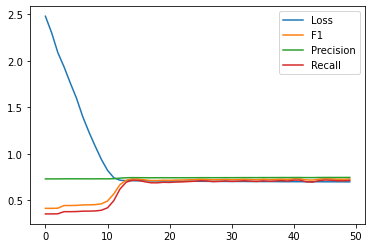

In [67]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(epoch_losses, label="Loss")
plt.plot(epoch_f1_scores, label='F1')
plt.plot(epoch_precision_scores, label="Precision")
plt.plot(epoch_recall_scores, label="Recall")
plt.legend()

In [ ]:
epochs = 200

# Training loop
gcn_net.train()
epoch_losses = []

epoch_f1_scores = [] 
epoch_precision_scores = []
epoch_recall_scores = []

for epoch in range(epochs):
    epoch_loss = 0

    preds = []
    labs = []
    # Train on batch
    for i, (bg, labels) in enumerate(train_loader):
        labels = labels.to(device)
        graph_feats = bg.ndata.pop('h').to(device)
        graph_feats, labels = graph_feats.to(device), labels.to(device)
        y_pred = gcn_net(bg, graph_feats)
        
        preds.append(y_pred.detach().numpy())
        labs.append(labels.detach().numpy())

        labels = np.argmax(labels, axis=1)
        
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        
    epoch_loss /= (i + 1)
    
    preds = np.vstack(preds)
    labs = np.vstack(labs)
    
    # There's some sort of issue going on here with the scoring. All three values are the same
    f1 = f1_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
    precision = precision_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
    recall = recall_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
    
    if epoch % 5 == 0:
        print(f"epoch: {epoch}, LOSS: {epoch_loss:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
        
    epoch_losses.append(epoch_loss)
    epoch_f1_scores.append(f1)
    epoch_precision_scores.append(precision)
    epoch_recall_scores.append(recall)

## Evaluate the model

In [69]:
test_loss =0
test_logits = []
preds = []
labs = []

net.eval()
for i, (bg, labels) in enumerate(test_loader):
    #labels = labels.to(device)
    logits = net(bg, bg.ndata['feats'])
    
    test_logits.append(logits.detach().numpy())
    labs.append(labels.unsqueeze(1).detach().numpy())

    #logp = F.log_softmax(logits, 1)
    
test_logits = np.vstack(test_logits)
labs = np.vstack(labs)

f1 = f1_score(labs, np.argmax(np.vstack(test_logits), axis=1), average='weighted')
precision = precision_score(labs, np.argmax(np.vstack(test_logits), axis=1), average='weighted')
recall = recall_score(labs, np.argmax(np.vstack(test_logits), axis=1), average='weighted')

print('Test: F1: %.4f | Precision: %.4f | Recall: %.4f' % (f1, precision, recall))

Test: F1: 0.6902 | Precision: 0.6895 | Recall: 0.6909


In [ ]:
# Evaluate
gcn_net.eval()
test_loss = 0

preds = []
labs = []
for i, (bg, labels) in enumerate(test_loader):
    labels = labels.to(device)
    graph_feats = bg.ndata.pop('h').to(device)
    graph_feats, labels = graph_feats.to(device), labels.to(device)
    y_pred = gcn_net(bg, graph_feats)

    preds.append(y_pred.detach().numpy())
    labs.append(labels.detach().numpy())

labs = np.vstack(labs)
preds = np.vstack(preds)

f1 = f1_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
precision = precision_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
recall = recall_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')

print(f"TEST F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")